In [57]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import confusion_matrix,plot_confusion_matrix, cohen_kappa_score, accuracy_score, classification_report, fbeta_score, make_scorer
from sklearn.metrics import mean_squared_error, r2_score
import math
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
pd.set_option('display.max_columns', None)
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.svm import LinearSVR
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
import seaborn as sns
from imblearn.under_sampling import TomekLinks


In [5]:
def clean_features(data):
    
    data=data.drop(columns=['Ties', 'Opponent Ties','Home','test'])
    data=data.dropna()
    data.columns=['Date', 'Team', 'Opponent', 'Score', 'Opponent Score',
       'Playoff Game?', 'Odds Open', 'Line Open', 'Win %', 'Total DVOA',
       'Offense DVOA', 'Defense DVOA', 'Special Teams DVOA', 'PassOffense',
       'RushOffense', 'PassDefense', 'RushDefense', 'Opponent Win %',
       'Opponent Total DVOA', 'Opponent Offense DVOA', 'Opponent Defense DVOA',
       'Opponent Special Teams DVOA', 'Opponent PassOffense',
       'Opponent RushOffense', 'Opponent PassDefense',
       'Opponent RushDefense', 'Wins', 'Losses', 'Opponent Wins',
       'Opponent Losses', 'Cover?']
    return data

In [7]:
def split_data(data):
    targets=data[['Score','Opponent Score','Odds Open','Line Open','Cover?']]
    features = data.drop(['Score','Opponent Score' ,'Odds Open', 'Wins' ,'Losses','Opponent Wins' ,'Opponent Losses' ,'Team', 'Date', 'Opponent','Cover?'],axis=1)
    features["Win %"] = pd.to_numeric(features["Win %"], downcast="float")
    features["Opponent Win %"] = pd.to_numeric(features["Opponent Win %"], downcast="float")
    numerical=features.select_dtypes(np.number)
    categorical=features.select_dtypes(np.object)
    dumcat=pd.get_dummies(categorical)
    features_final=pd.concat([numerical, dumcat],axis=1)
    return features_final,targets

In [38]:
def run_model2(model,X,Y,scaled):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)
    
    
    if scaled=="yes":
        scaler_x = StandardScaler().fit(X_train)
        X_train_scaled = pd.DataFrame(scaler_x.transform(X_train),columns=X.columns)
        X_test_scaled = pd.DataFrame(scaler_x.transform(X_test),columns=X.columns)
    elif scaled=="no":
        X_train_scaled=X_train
        X_test_scaled=X_test
    pm = model
    regression = pm.fit(X_train_scaled, y_train['Score'])
    predictions = regression.predict(X_test_scaled)
    predictions_df = pd.DataFrame(predictions,columns=["pred_scores"])
    mse = mean_squared_error(y_test['Score'], predictions)
    print("The MSE value is: ",round(mse,4))
    
    rmse = math.sqrt(mse)
    print("The RMSE value is: ",round(rmse,4))
    
    r2 = r2_score(y_test['Score'], predictions)
    print("The R2 value is: ",round(r2,4))
    
    N = len(X_test_scaled)
    p = X_test_scaled.shape[1]
    adj_r2 = 1-((1-r2)*(N-1)/(N-p-1))
    print("The R_adj^{2} value  is: ",round(adj_r2,4))

    regression2 = pm.fit(X_train_scaled, y_train['Opponent Score'])
    predictions2 = regression2.predict(X_test_scaled)
    predictions_df2 = pd.DataFrame(predictions2,columns=["Opp_pred_scores"])
    
    
    mse = mean_squared_error(y_test['Opponent Score'], predictions2)
    print("The MSE value is: ",round(mse,4))
    
    rmse = math.sqrt(mse)
    print("The RMSE value is: ",round(rmse,4))
    
    r2 = r2_score(y_test['Opponent Score'], predictions2)
    print("The R2 value is: ",round(r2,4))
    
    N = len(X_test_scaled)
    p = X_test_scaled.shape[1]
    adj_r2 = 1-((1-r2)*(N-1)/(N-p-1))
    print("The R_adj^{2} value  is: ",round(adj_r2,4))
    
    final=pd.concat([X_test, y_test],axis=1)
    passoff=list(final['PassOffense'])
    rushoff=list(final['RushOffense'])
    opppassdef=list(final['Opponent PassDefense'])
    opprushdef=list(final['Opponent RushDefense'])
    opppassoff=list(final['Opponent PassOffense'])
    opprushoff=list(final['Opponent RushOffense'])
    passdef=list(final['PassDefense'])
    rushdef=list(final['RushDefense'])
    for i in range (len(passoff)):
        if (passoff[i]+opppassdef[i])>0:
            predictions[i]=predictions[i]+1
    for i in range (len(passoff)):
        if (rushoff[i]+opprushdef[i])>0:
            predictions[i]=predictions[i]+1
    for i in range (len(passoff)):
        if (opppassoff[i]+passdef[i])>0:
            predictions2[i]=predictions2[i]+1
    for i in range (len(rushoff)):
        if (opprushoff[i]+rushdef[i])>0:
            predictions2[i]=predictions2[i]+1
    
    final['predictions']=predictions
    final['opp predictions']=predictions2
    
    finalscore=list(final['Score'])
    finalline=list(final['Line Open'])
    finalopp=list(final['Opponent Score'])
    finalcover=[]
    for i in range(len(finalscore)):
        if (finalscore[i]+finalline[i])*1.0>finalopp[i]:
            finalcover.append('Yes')
        else:
            finalcover.append('No')
    final['Cover?']=finalcover
    
    predfinalscore=list(final['predictions'])
    predfinalline=list(final['Line Open'])
    predfinalopp=list(final['opp predictions'])
    predfinalcover=[]

      
    for i in range(len(predfinalscore)):
        if (predfinalscore[i])+predfinalline[i]>(predfinalopp[i]):
            predfinalcover.append('Yes')
        else:
            predfinalcover.append('No')
    
    safebet=[]
    for i in range(len(finalscore)):
        if (predfinalscore[i]+predfinalline[i])>(predfinalopp[i]+3.5):
            safebet.append('Yes')
        elif (predfinalscore[i]+(predfinalline[i]+3.5))<predfinalopp[i]:   
            safebet.append('Yes')
        else:
            safebet.append('No')
    final['safebet?']=safebet

    final['Pred_Cover?']=predfinalcover  
    final['Cover?']=finalcover
    
    safepredfinalscore=list(final['predictions'][final['safebet?'] == 'Yes'])
    safepredfinalline=list(final['Line Open'][final['safebet?'] == 'Yes'])
    safepredfinalopp=list(final['opp predictions'][final['safebet?'] == 'Yes'])
    safepredfinalcover=[]

      
    for i in range(len(safepredfinalscore)):
        if (safepredfinalscore[i])+safepredfinalline[i]>(safepredfinalopp[i]):
            safepredfinalcover.append('Yes')
        else:
            safepredfinalcover.append('No')
    
    print("Model Results")
    print("The accuracy of the model on test set is: %4.2f " % accuracy_score(final['Cover?'], predfinalcover))
    print("The Kappa of your model is: %4.2f" % (cohen_kappa_score(final['Cover?'], predfinalcover)))
    print(cohen_kappa_score)
    print("------ Classification_Report------ ")
    print(classification_report(final['Cover?'], predfinalcover))
    print(" =================================================================== ")
    


    print("Safe Model Results")
    print("The accuracy of the model on test set is: %4.2f " % accuracy_score(final['Cover?'][final['safebet?'] == 'Yes'], safepredfinalcover))
    print("The Kappa of your model is: %4.2f" % (cohen_kappa_score(final['Cover?'][final['safebet?'] == 'Yes'], safepredfinalcover)))
    print(cohen_kappa_score)
    print("------ Classification_Report------ ")
    print(classification_report(final['Cover?'][final['safebet?'] == 'Yes'], safepredfinalcover))
    print(" =================================================================== ")
    return final,X_train_scaled,y_train


In [59]:
data=pd.read_csv(r"C:\Users\Nickolaus Smith\Desktop\Final Project\lines4.csv")

In [65]:
data = data[data.Home != 'Y']

In [66]:
data.columns

Index(['Date', 'Team', 'Opponent', ' Score', 'Opponent Score', 'Home',
       'Playoff Game?', ' Odds Open', ' Line Open', 'Win %', 'Total DVOA',
       'Offense DVOA', 'Defense DVOA', 'Special Teams DVOA', 'PassOffense',
       'RushOffense', 'PassDefense', 'RushDefense', 'Opponent Win %',
       'Opponent Total DVOA', 'Opponent Offense DVOA', 'Opponent Defense DVOA',
       'Opponent Special Teams DVOA', 'Opponent PassOffense',
       'Opponent RushOffense', 'test', 'Opponent PassDefense',
       'Opponent RushDefense', 'Wins', 'Losses', 'Ties', 'Opponent Wins',
       'Opponent Losses', 'Opponent Ties', 'Cover?'],
      dtype='object')

C:\Users\Nickolaus Smith\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


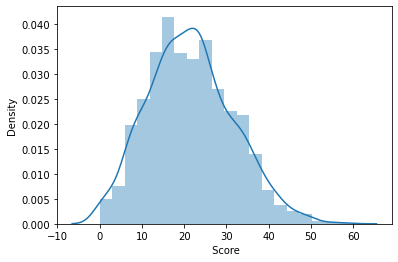

In [67]:
sns.distplot(data[' Score'],bins=20)
plt.show()

C:\Users\Nickolaus Smith\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


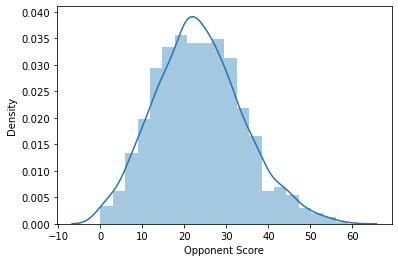

In [68]:
sns.distplot(data['Opponent Score'],bins=20)
plt.show()

In [6]:
data=clean_features(data)

In [8]:
features_final,targets=split_data(data)

In [9]:
features_final=features_final.drop(['Offense DVOA','Defense DVOA','Opponent Offense DVOA','Opponent Defense DVOA','Win %', 'Opponent Win %'],axis=1)

In [58]:
features_final

,Line Open,Total DVOA,Special Teams DVOA,PassOffense,RushOffense,PassDefense,RushDefense,Opponent Total DVOA,Opponent Special Teams DVOA,Opponent PassOffense,Opponent RushOffense,Opponent PassDefense,Opponent RushDefense,Playoff Game?_N,Playoff Game?_Y
13,-3.5,0.195,0.005,0.490,-0.056,0.067,0.026,0.316,-0.029,0.371,-0.020,-0.054,-0.314,0,1
14,2.5,0.238,0.059,0.433,-0.150,0.022,-0.082,0.195,0.005,0.490,-0.056,0.067,0.026,0,1
15,4.0,0.316,-0.029,0.371,-0.020,-0.054,-0.314,0.259,-0.027,0.520,0.030,0.051,-0.057,0,1
16,3.5,0.316,-0.029,0.371,-0.020,-0.054,-0.314,0.333,0.036,0.166,0.095,-0.147,-0.256,0,1
17,10.0,-0.056,-0.037,0.209,-0.008,0.164,-0.054,0.195,0.005,0.490,-0.056,0.067,0.026,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4439,-4.0,-0.045,-0.011,-0.124,-0.127,-0.020,-0.285,-0.297,-0.027,0.105,-0.089,0.294,0.160,1,0
4440,13.0,-0.068,0.036,-0.106,-0.125,-0.006,-0.036,0.314,0.058,0.499,0.087,0.005,-0.045,1,0
4441,3.0,0.129,-0.018,0.035,0.195,0.013,-0.138,0.148,-0.077,0.248,-0.131,-0.163,-0.264,1,0
4442,13.0,-0.334,-0.018,0.025,-0.114,0.430,0.043,0.318,0.012,0.336,0.207,-0.093,-0.172,1,0


In [10]:
X=features_final
y=targets[['Score','Opponent Score']]

In [29]:
RF_final2,X_train_scaled,y_train=run_model2(RandomForestRegressor(max_depth=None, random_state=10,min_samples_split=3,min_samples_leaf=3),X,y,"yes")

The MSE value is:  81.9234
The RMSE value is:  9.0512
The R2 value is:  0.1332
The R_adj^{2} value  is:  0.1132
The MSE value is:  96.0524
The RMSE value is:  9.8006
The R2 value is:  0.0587
The R_adj^{2} value  is:  0.0369
Model Results
The accuracy of the model on test set is: 0.54 
The Kappa of your model is: 0.08
<function cohen_kappa_score at 0x0000024C38B15A60>
------ Classification_Report------ 
              precision    recall  f1-score   support

          No       0.52      0.48      0.50       316
         Yes       0.56      0.60      0.58       348

    accuracy                           0.54       664
   macro avg       0.54      0.54      0.54       664
weighted avg       0.54      0.54      0.54       664

Safe Model Results
The accuracy of the model on test set is: 0.61 
The Kappa of your model is: 0.15
<function cohen_kappa_score at 0x0000024C38B15A60>
------ Classification_Report------ 
              precision    recall  f1-score   support

          No       0.56  

In [53]:
SVR_final,z,q=run_model2(make_pipeline(LinearSVR(random_state=0, tol=1e-5)),X,y,"yes")

The MSE value is:  80.3968
The RMSE value is:  8.9664
The R2 value is:  0.1494
The R_adj^{2} value  is:  0.1297
The MSE value is:  91.3627
The RMSE value is:  9.5584
The R2 value is:  0.1046
The R_adj^{2} value  is:  0.0839
Model Results
The accuracy of the model on test set is: 0.51 
The Kappa of your model is: 0.01
<function cohen_kappa_score at 0x0000024C38B15A60>
------ Classification_Report------ 
              precision    recall  f1-score   support

          No       0.48      0.50      0.49       316
         Yes       0.53      0.51      0.52       348

    accuracy                           0.51       664
   macro avg       0.51      0.51      0.51       664
weighted avg       0.51      0.51      0.51       664

Safe Model Results
The accuracy of the model on test set is: 0.64 
The Kappa of your model is: 0.24
<function cohen_kappa_score at 0x0000024C38B15A60>
------ Classification_Report------ 
              precision    recall  f1-score   support

          No       0.57  

In [56]:
DT_final,z,q=run_model2(DecisionTreeRegressor(),X,y,"yes")

The MSE value is:  193.2018
The RMSE value is:  13.8997
The R2 value is:  -1.0441
The R_adj^{2} value  is:  -1.0914
The MSE value is:  203.7651
The RMSE value is:  14.2746
The R2 value is:  -0.997
The R_adj^{2} value  is:  -1.0432
Model Results
The accuracy of the model on test set is: 0.53 
The Kappa of your model is: 0.05
<function cohen_kappa_score at 0x0000024C38B15A60>
------ Classification_Report------ 
              precision    recall  f1-score   support

          No       0.50      0.53      0.52       316
         Yes       0.55      0.52      0.53       348

    accuracy                           0.53       664
   macro avg       0.53      0.53      0.53       664
weighted avg       0.53      0.53      0.53       664

Safe Model Results
The accuracy of the model on test set is: 0.53 
The Kappa of your model is: 0.07
<function cohen_kappa_score at 0x0000024C38B15A60>
------ Classification_Report------ 
              precision    recall  f1-score   support

          No      

In [34]:
LR_final[LR_final['safebet?'] == 'Yes']

,Line Open,Total DVOA,Special Teams DVOA,PassOffense,RushOffense,PassDefense,RushDefense,Opponent Total DVOA,Opponent Special Teams DVOA,Opponent PassOffense,Opponent RushOffense,Opponent PassDefense,Opponent RushDefense,Playoff Game?_N,Playoff Game?_Y,Score,Opponent Score,predictions,opp predictions,Cover?,safebet?,Pred_Cover?
4264,-4.0,0.164,-0.015,0.282,0.153,0.048,-0.120,-0.075,-0.056,-0.141,0.127,0.007,-0.042,1,0,38,28,26.592800,18.060606,Yes,Yes,Yes
1209,3.0,0.076,0.004,0.347,-0.008,0.175,-0.095,-0.195,-0.065,-0.165,-0.230,-0.066,-0.101,0,1,14,27,22.260493,21.273069,No,Yes,Yes
3570,6.5,0.132,0.018,0.492,-0.021,0.154,-0.046,0.264,-0.015,0.094,-0.011,-0.308,-0.270,0,1,24,35,21.477663,23.735961,No,Yes,Yes
1294,2.5,0.036,-0.035,0.330,-0.014,0.185,-0.129,-0.021,-0.073,-0.122,-0.065,-0.140,-0.250,1,0,48,41,22.427941,21.361963,Yes,Yes,Yes
2808,-3.0,-0.139,0.019,0.019,-0.076,0.220,-0.012,-0.222,-0.055,-0.363,-0.136,-0.011,-0.207,1,0,14,41,22.796672,16.065327,No,Yes,Yes
1793,7.0,0.230,-0.023,0.499,-0.008,0.049,-0.065,0.318,-0.017,0.287,0.234,-0.076,-0.276,0,1,22,28,23.469248,26.952436,Yes,Yes,Yes
2126,-12.0,0.333,-0.012,0.581,0.065,0.101,-0.180,-0.336,-0.068,-0.165,-0.028,0.224,-0.067,1,0,34,14,31.483011,15.515343,Yes,Yes,Yes
2155,-10.5,0.302,-0.006,0.565,0.041,0.127,-0.181,-0.259,-0.071,-0.168,-0.124,0.136,-0.169,1,0,37,13,30.393605,16.236455,Yes,Yes,Yes
1304,-3.0,-0.024,0.001,0.086,-0.069,0.073,-0.078,-0.374,-0.071,-0.202,-0.035,0.348,-0.215,1,0,34,13,23.948441,17.097527,Yes,Yes,Yes
3574,-3.5,0.306,0.017,0.161,0.028,-0.197,-0.252,0.042,-0.079,-0.027,-0.093,-0.193,-0.261,0,1,26,14,23.426482,16.337091,Yes,Yes,Yes


In [ ]:
rfpred=list(RF_final2{'Pred_Cover'})
lmpred=list(RF_final2{'Pred_Cover'})

In [22]:
RF_final2

,Line Open,Total DVOA,Special Teams DVOA,PassOffense,RushOffense,PassDefense,RushDefense,Opponent Total DVOA,Opponent Special Teams DVOA,Opponent PassOffense,Opponent RushOffense,Opponent PassDefense,Opponent RushDefense,Playoff Game?_N,Playoff Game?_Y,Score,Opponent Score,predictions,opp predictions,Cover?,safebet?,Pred_Cover?
826,7.0,0.101,-0.043,0.042,0.087,-0.112,-0.096,0.227,-0.076,0.509,0.046,0.009,-0.141,1,0,23,22,20.873173,29.217981,Yes,No,No
2607,-3.0,0.313,0.017,0.452,-0.145,-0.014,-0.183,0.027,-0.079,0.323,0.020,0.256,-0.197,1,0,24,20,29.034231,23.630580,Yes,No,Yes
4118,3.0,-0.155,-0.077,0.202,-0.107,0.244,0.012,-0.152,-0.054,-0.076,-0.209,-0.084,-0.101,1,0,27,11,21.863214,24.294597,Yes,No,Yes
4264,-4.0,0.164,-0.015,0.282,0.153,0.048,-0.120,-0.075,-0.056,-0.141,0.127,0.007,-0.042,1,0,38,28,26.224877,19.168283,Yes,No,Yes
3598,2.0,0.041,-0.041,0.155,0.066,-0.025,-0.065,0.288,0.012,0.149,0.051,-0.159,-0.266,1,0,6,44,18.998460,23.558616,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2332,-1.0,-0.057,-0.039,0.254,0.116,0.277,-0.044,0.126,-0.030,0.367,0.138,0.232,-0.132,1,0,27,13,26.182780,28.822891,Yes,No,No
3039,3.5,-0.021,0.016,0.116,-0.130,0.031,-0.038,0.065,-0.014,0.165,-0.067,0.050,-0.197,1,0,34,27,22.975928,24.506656,Yes,No,Yes
1103,2.5,0.010,-0.098,0.342,-0.170,-0.074,-0.010,0.065,0.053,0.123,0.062,0.077,0.024,1,0,28,6,18.927250,25.802414,Yes,No,No
2836,-2.0,-0.145,-0.077,0.137,0.194,0.220,0.137,-0.338,-0.029,-0.279,-0.138,-0.019,0.053,1,0,38,19,27.541841,19.024330,Yes,Yes,Yes


In [23]:
final['safebet?'] == 'Yes']

SyntaxError: unmatched ']' (<ipython-input-23-64d6cc2e467e>, line 1)

In [24]:
combodf=RF_final2

In [25]:
combodf['combo']=combo

NameError: name 'combo' is not defined

In [48]:
rfpred=list(LR_final['Pred_Cover?'])
LRpred=list(LR_final['Pred_Cover?'])
combo=[]

In [49]:
for i in range(len(rfpred)):
    if rfpred[i]==LRpred[i]:
        combo.append('Yes')
    else:   
        combo.append('No')

In [50]:
combodf=LR_final
combodf['combo']=combo
combodf2=combodf[combodf['combo'] == 'Yes']
ombodfsafe=combodf2[combodf2['safebet?'] == 'Yes']

In [52]:
    print("Model Results")
    print("The accuracy of the model on test set is: %4.2f " % accuracy_score(combodf2['Cover?'], combodf2['Pred_Cover?']))
    print("The Kappa of your model is: %4.2f" % (cohen_kappa_score(combodf2['Cover?'], combodf2['Pred_Cover?'])))
    print(cohen_kappa_score)
    print("------ Classification_Report------ ")
    print(classification_report(combodf2['Cover?'], combodf2['Pred_Cover?']))
    print(" =================================================================== ")

Model Results
The accuracy of the model on test set is: 0.51 
The Kappa of your model is: 0.01
<function cohen_kappa_score at 0x0000024C38B15A60>
------ Classification_Report------ 
              precision    recall  f1-score   support

          No       0.48      0.50      0.49       316
         Yes       0.53      0.51      0.52       348

    accuracy                           0.51       664
   macro avg       0.51      0.51      0.51       664
weighted avg       0.51      0.51      0.51       664

